# Birds Classification Boosting

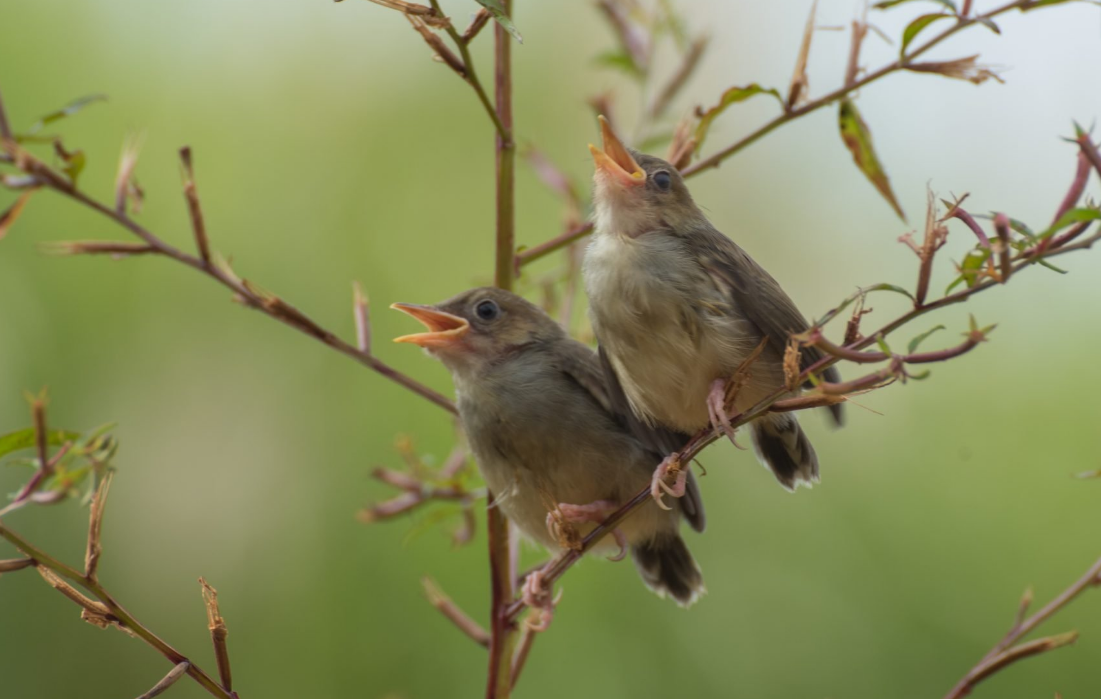

In [1]:
import os
import glob
import shutil
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm
from IPython.display import Audio
import pandas as pd
import pickle
from joblib import dump, load
from pathlib import Path
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

!pip install optuna-integration -q
import optuna
import lightgbm as lgb
from catboost import CatBoostClassifier

RANDOM_SEED = 12345

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 2.1 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.0
    Uninstalling imbalanced-learn-0.12.0:
      Successfully uninstalled imbalanced-learn-0.12.0


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
df = pd.read_csv('/kaggle/input/birdclef-2024/train_metadata.csv')
df.head(4)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg


In [3]:
dataset_dir = '/kaggle/input/birdclef-2024/train_audio'

label_mapping = {}
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for audio_file in os.listdir(label_dir):
            audio_file_path = os.path.join(label_dir, audio_file)
            label_mapping[audio_file_path] = label
            
data = [(audio_file_path, label) for audio_file_path, label in label_mapping.items()]
annotated_data = pd.DataFrame(data, columns=['audio_file_path', 'label'])
annotated_data.head(2)

,audio_file_path,label
0,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1
1,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1


## FEATURE ENGINEERING

* ###   Feature Extraction + Augmentations

In [ ]:
def noising(data,noise_factor):
    """
    Add noise to original data.
    Adjust noise factor how much you want to add.
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shifting(data, sampling_rate, shift_max, shift_direction):
    shift = np.random.randint(sampling_rate * shift_max+1)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def change_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def pitch_speed(data, low=0.8, high = 1):
    augmented_data = data.copy() 
    length_change = np.random.uniform(low=low, high = high) #change low and high here
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0, len(augmented_data), speed_fac), np.arange(0, len(augmented_data)), augmented_data)
    minlen = min(data.shape[0], tmp.shape[0])
    augmented_data *= 0
    augmented_data[0:minlen] = tmp[0:minlen]
    return augmented_data

def change_speed(data, low=0.9, high = 1.1):
    augmented_data = data.copy() 
    speed_change = np.random.uniform(low=low, high=high)
    tmp = librosa.effects.time_stretch(y = augmented_data.astype('float64'), rate=speed_change)
    minlen = min(augmented_data.shape[0], tmp.shape[0])
    augmented_data *= 0 
    augmented_data[0:minlen] = tmp[0:minlen]
    return augmented_data

def value_aug(data, low=1.5, high=3):
    dyn_change = np.random.uniform(low=low, high=high)
    augmented_data = data * dyn_change
    return augmented_data

def hpss(data):
    augmented_data = librosa.effects.hpss(data.astype('float64')) 
    return augmented_data[1]

def streching(data, rate=1.1):
    input_length = len(data) 
    augmented_data = librosa.effects.time_stretch(y=data.astype('float'), rate=1.1)
    if len(augmented_data) > input_length:
        augmented_data = augmented_data[:input_length]
    else:
        augmented_data = np.pad(augmented_data, (0, max(0, input_length - len(augmented_data))), 'constant')
    return augmented_data

In [4]:
def extract_features(file_path):
    sig, sr = librosa.load(file_path)
    augmentations = [(noising, [sig, np.random.uniform(0,0.1)]), (shifting, [sig, sr, 0.8,'right']),
                     (pitch_speed, [sig]), (change_pitch, [sig, sr, np.random.randint(-5,5)]),
                     (change_speed,[sig]), (value_aug, [sig]), (hpss, [sig]), (streching, [sig])]
    
    aug = random.choices([True, False], weights=[0.3, 0.7])
    if aug:
        random_aug = random.randint(0, len(augmentations)-1)
        audio_data = augmentations[random_aug][0](*augmentations[random_aug][1])
    # Extract features using Mel-Frequency Cepstral Coefficients (MFCC)
    mfccs = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=40)
    flattened_features = np.mean(mfccs.T, axis=0) #1D
    return flattened_features

def load_data_and_extract_features(data_dir):
    labels, features = [], []
    for filename in os.listdir(data_dir):
        if filename.endswith('.ogg'):
            file_path = os.path.join(data_dir, filename)
            label = filename.split('-')[0]
            labels.append(label)
            feature = extract_features(file_path)
            features.append(feature)
    return np.array(features), np.array(labels)

In [ ]:
extracted_features = []

for i in tqdm(annotated_data['audio_file_path']):
    features = extract_features(file_path=i)
    extracted_features.append(features)
    
with open('extracted_features', 'wb') as file:   #Pickling
    pickle.dump(extracted_features, file)


 21%|██        | 5192/24459 [14:14<1:09:45,  4.60it/s]]

In [4]:
with open('/kaggle/input/extracted-features-pickle/extracted_features', 'rb') as file:  
    pickled_extracted_features = pickle.load(file)

* ### Label Encoding

In [5]:
label_encoder = LabelEncoder()
annotated_data['encoded_label'] = label_encoder.fit_transform(annotated_data['label'])
annotated_data.head(2)

,audio_file_path,label,encoded_label
0,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137
1,/kaggle/input/birdclef-2024/train_audio/redspu...,redspu1,137


* ### Random Sampling Data

In [6]:
x = np.vstack(pickled_extracted_features)
y = annotated_data['encoded_label']

print(f'features shape: {x.shape}, labels shape: {y.shape}')

ros = RandomOverSampler(random_state=RANDOM_SEED)
features_resampled, labels_reshampled = ros.fit_resample(x, y)

print(features_resampled.shape)
print(labels_reshampled.shape)

print(f'features_resampled shape: {features_resampled.shape}, labels_reshampled shape: {labels_reshampled.shape}')

features shape: (24459, 40), labels shape: (24459,)
(91000, 40)
(91000,)
features_resampled shape: (91000, 40), labels_reshampled shape: (91000,)


# TRAINING

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_reshampled, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
param_distrs = {
                'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1),,
                'depth': optuna.distributions.IntDistribution(5,8),
                'l2_leaf_reg': optuna.distributions.FloatDistribution(0.01,95.),
                }

clf = CatBoostClassifier(verbose=False, random_seed=RANDOM_SEED, task_type='GPU', devices='0')
opt_search = optuna.integration.OptunaSearchCV(clf, param_distrs, cv = 3,
                                                n_trials=50, scoring='f1_macro', timeout=500)
opt_search.fit(x_train, y_train)

opt_search.best_estimator_

In [8]:
result = {'variant': [], 'accuracy': [], 'precision': [],
          'recall': [], 'f1': []}

def get_metrics(komm, y_test, y_pred, average = 'macro'):
    result['variant'].append(komm)
    result['accuracy'].append(accuracy_score(y_test, y_pred))
    result['precision'].append(precision_score(y_test, y_pred, average=average))
    result['recall'].append(recall_score(y_test, y_pred, average=average))
    result['f1'].append(f1_score(y_test, y_pred, average=average))
    
def get_classification_report_vizualisis(y_test, y_pred):
    result = pd.DataFrame(classification_report(y_test, y_pred,output_dict=True)).T
    result = result.iloc[:-3]

    plt.title('Dependence of the metric on the amount of data')
    sns.scatterplot(result, x = 'support', y = 'f1-score', color = 'forestgreen')
    plt.show()

* ### Without augmentations

In [9]:
model = CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='TotalF1',metric_period=1000, learning_rate = 0.05, 
                       depth=7, l2_leaf_reg=0.01, min_data_in_leaf=6, task_type='GPU', devices='0')
model.fit(x_train, y_train)

0:	learn: 0.0410545	total: 943ms	remaining: 15m 41s
999:	learn: 0.9999313	total: 7m 33s	remaining: 0us


In [11]:
y_pred = model.predict(x_test)
get_metrics('default', y_test, y_pred)
res = pd.DataFrame(result)
display(res.loc[res.variant=='default'])

get_classification_report_vizualisis(y_test, y_pred)

,variant,accuracy,precision,recall,f1
0,default,0.89044,0.893012,0.891129,0.891495


* ### Without augmentations + StratifiedKFold

In [13]:
annotations = pd.DataFrame(features_resampled, labels_reshampled).reset_index()
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

for fold, ( _, val_) in enumerate(skf.split(X=annotations, y=annotations.encoded_label)):
      annotations.loc[val_ , 'kfold'] = int(fold)
        
df_train = annotations[annotations.kfold != 0].reset_index(drop=True)
df_test = annotations[annotations.kfold == 0].reset_index(drop=True)

y_train, y_test = df_train['encoded_label'], df_test['encoded_label']
x_train, x_test = df_train.drop(['encoded_label'], axis = 1), df_test.drop(['encoded_label'], axis = 1)

In [14]:
model_skf = CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='TotalF1',metric_period=1000, learning_rate = 0.05, 
                       depth=7, l2_leaf_reg=0.01, min_data_in_leaf=6, task_type='GPU', devices='0')
model_skf.fit(x_train, y_train)

0:	learn: 0.0436649	total: 654ms	remaining: 10m 53s
999:	learn: 0.9998901	total: 8m 2s	remaining: 0us


,variant,accuracy,precision,recall,f1
1,default_StratifiedKFold,0.89956,0.901378,0.89956,0.899516


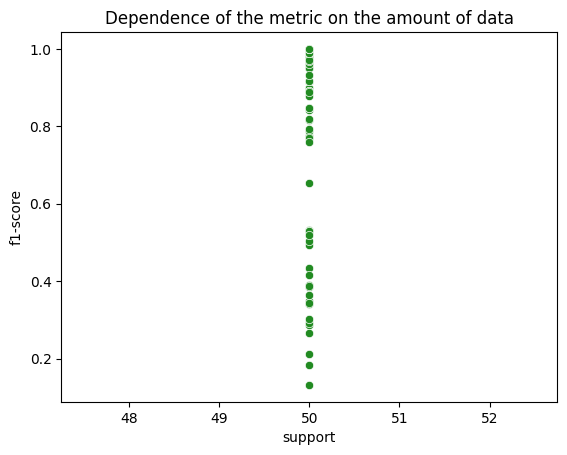

In [ ]:
y_pred = model_skf.predict(x_test)
get_metrics('default_StratifiedKFold', y_test, y_pred)
res = pd.DataFrame(result)
display(res.loc[res.variant=='default_StratifiedKFold'])

get_classification_report_vizualisis(y_test, y_pred)

* ### With augmentations

In [ ]:
with open('/kaggle/input/extracted-features-birds/extracted_features', 'rb') as file:  
    birds_extracted_features = pickle.load(file)
x = np.vstack(birds_extracted_features)
y = annotated_data['encoded_label']
ros = RandomOverSampler(random_state=RANDOM_SEED)
features_resampled_birds, labels_reshampled_birds = ros.fit_resample(x, y)
x_train, x_test, y_train, y_test = train_test_split(features_resampled_birds, labels_reshampled_birds, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
model_wa = CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='TotalF1',metric_period=1000, learning_rate = 0.05, 
                       depth=7, l2_leaf_reg=0.01, min_data_in_leaf=6, task_type='GPU', devices='0')
model_wa.fit(x_train, y_train)

0:	learn: 0.0410545	total: 512ms	remaining: 8m 31s
999:	learn: 0.9998489	total: 7m 36s	remaining: 0us


,variant,accuracy,precision,recall,f1
2,augmentations,0.889945,0.892272,0.8907,0.890884


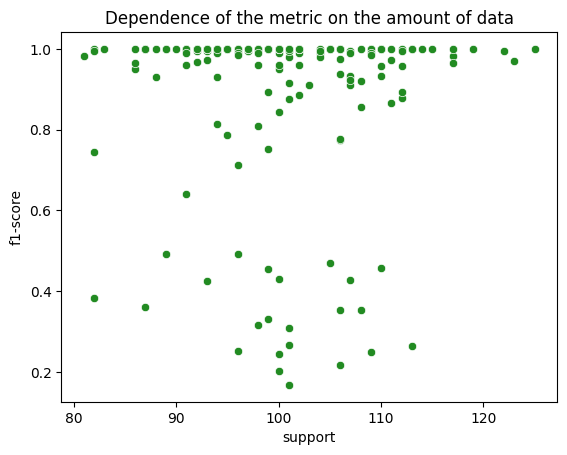

In [ ]:
y_pred = model_wa.predict(x_test)
get_metrics('augmentations', y_test, y_pred)
res = pd.DataFrame(result)
display(res.loc[res.variant=='augmentations'])
        
get_classification_report_vizualisis(y_test, y_pred)

* ### With augmentations + StratifiedKFold

In [ ]:
annotations = pd.DataFrame(features_resampled_birds, labels_reshampled_birds).reset_index()
skf = StratifiedKFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

for fold, ( _, val_) in enumerate(skf.split(X=annotations, y=annotations.encoded_label)):
      annotations.loc[val_ , 'kfold'] = int(fold)
        
df_train = annotations[annotations.kfold != 0].reset_index(drop=True)
df_test = annotations[annotations.kfold == 0].reset_index(drop=True)

y_train, y_test = df_train['encoded_label'], df_test['encoded_label']
x_train, x_test = df_train.drop(['encoded_label'], axis = 1), df_test.drop(['encoded_label'], axis = 1)

In [97]:
model_wa_skf = CatBoostClassifier(random_seed=RANDOM_SEED, eval_metric='TotalF1',metric_period=1000, learning_rate = 0.05, 
                       depth=7, l2_leaf_reg=0.01, min_data_in_leaf=6, task_type='GPU', devices='0')
model_wa_skf.fit(x_train, y_train)

0:	learn: 0.0433505	total: 670ms	remaining: 11m 9s
999:	learn: 0.9998750	total: 8m 25s	remaining: 0us


,variant,accuracy,precision,recall,f1
3,augmentations_StratifiedKFold,0.899560,0.901378,0.899560,0.899516
4,augmentations_StratifiedKFold,0.900132,0.903675,0.900452,0.900808


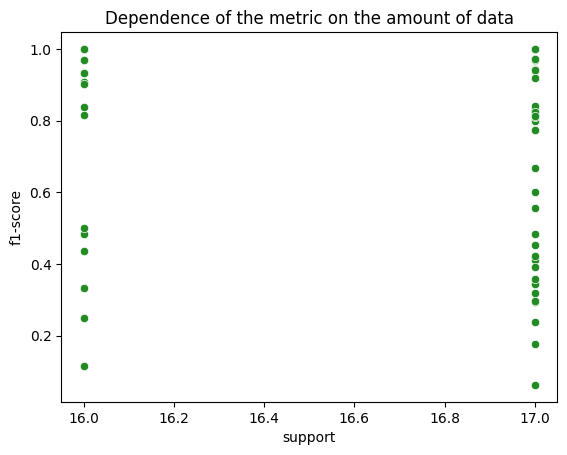

In [99]:
y_pred = model_wa_skf.predict(x_test)
get_metrics('augmentations_StratifiedKFold', y_test, y_pred)
res = pd.DataFrame(result)
display(res.loc[res.variant=='augmentations_StratifiedKFold'])

get_classification_report_vizualisis(y_test, y_pred)

In [100]:
res

,variant,accuracy,precision,recall,f1
0,default,0.890440,0.893012,0.891129,0.891495
1,default_StratifiedKFold,0.899560,0.901378,0.899560,0.899516
2,augmentations,0.889945,0.892272,0.890700,0.890884
3,augmentations_StratifiedKFold,0.899560,0.901378,0.899560,0.899516
4,augmentations_StratifiedKFold,0.900132,0.903675,0.900452,0.900808


In [ ]:
dump(model_wa_skf, 'audio_classifier_model.joblib')

['audio_classifier_model.joblib']

# INFERENCE

In [ ]:
def audio_classification(file_path):
    extracted_features = extract_features(file_path).reshape(1, -1)
    y_predict = model.predict(extracted_features)
    labels_list = annotated_data['label'].unique()
    encoded_label = annotated_data['encoded_label'].unique()

    labels = {}
    for label, prediction in zip(encoded_label, labels_list):
        labels[label] = prediction
    if y_predict[0][0] in labels.keys():
        predicted = ('Predicted Class:', labels[y_predict[0][0]])
    return predicted

In [58]:
model = load('/kaggle/working/audio_classifier_model.joblib')
test_soundscapes = '/kaggle/input/birdclef-2024/test_soundscapes'

for path in Path(test_soundscapes).glob("*.ogg"):
    print(path)
    print(path.stem)
    print(path.stem.split("_"))

In [50]:
test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(test_soundscapes).glob("*.ogg")],
    columns = ["filename", "name" ,"id", "path"]
)
print(test.shape)
test.head()

(0, 4)


,filename,name,id,path


In [52]:
filenames = test.filename.values.tolist()

bird_cols = list(pd.get_dummies(df['primary_label']).columns)
submission_df = pd.DataFrame(columns=['row_id']+bird_cols)
submission_df

,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1


In [56]:
for i, file in enumerate(filenames):
    predicted = model.predict[i]
    num_rows = len(predicted)
    row_ids = [f'{file}_{(i+1)*5}' for i in range(num_rows)]
    df = pd.DataFrame(columns=['row_id']+bird_cols)
    
    df['row_id'] = row_ids
    df[bird_cols] = predicted
    
    submission_df = pd.concat([submission_df,df]).reset_index(drop=True)
    submission_df

In [54]:
submission_df.to_csv('sample_submission.csv', index=False)